LOADING DATA

In [1]:
import geopandas as gpd

In [2]:
from IPython.display import Image
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter("ignore")

load data for 'train.csv'

In [3]:
df = pd.read_csv('train.csv', parse_dates = ['Occurrence Local Date Time'])#use parse_dates to turn the column to datetime type
df.head()

,EventId,Occurrence Local Date Time,Reporting Agency,Cause,Subcause,Status,longitude,latitude,road_segment_id
0,60558,2016-01-01 00:53:00,Cam,Stationary Vehicle,Vehicle On Shoulder,Closed,18.5408955032,-33.888275,S0B3CGQ
1,60559,2016-01-01 00:54:00,CAMERA,Accident,With A Fixed Object,Closed,18.9307563219,-34.140857,RYJYAPI
2,60560,2016-01-01 02:26:00,Law Enforcement,Accident,Multi Vehicle,Closed,18.5533575029,-33.959154,U3KP57C
3,60561,2016-01-01 02:56:00,CAMERA,Stationary Vehicle,Vehicle On Shoulder,Closed,18.6775561589,-33.895258,RY0TRQ8
4,60562,2016-01-01 03:40:00,CAMERA,Accident,Multi Vehicle,Closed,18.8371319682,-34.087051,8LOVJZ3


In [4]:
df.shape

(53845, 9)

In [5]:
df.dtypes

EventId                                int64
Occurrence Local Date Time    datetime64[ns]
Reporting Agency                      object
Cause                                 object
Subcause                              object
Status                                object
longitude                             object
latitude                             float64
road_segment_id                       object
dtype: object

In [6]:
#turn longitude into numeric
df['longitude'] = pd.to_numeric(df.longitude, errors='coerce')

MISSING VALUES

In [7]:
df.isna().sum()

EventId                          0
Occurrence Local Date Time       0
Reporting Agency              1619
Cause                            0
Subcause                         0
Status                           0
longitude                        5
latitude                         0
road_segment_id                  0
dtype: int64

In [8]:
#drop Reporting Agency column (not as useful to predict the aciidents and there are too many missing values)
df = df.drop(columns = 'Reporting Agency', axis=1)
df.head()

,EventId,Occurrence Local Date Time,Cause,Subcause,Status,longitude,latitude,road_segment_id
0,60558,2016-01-01 00:53:00,Stationary Vehicle,Vehicle On Shoulder,Closed,18.540896,-33.888275,S0B3CGQ
1,60559,2016-01-01 00:54:00,Accident,With A Fixed Object,Closed,18.930756,-34.140857,RYJYAPI
2,60560,2016-01-01 02:26:00,Accident,Multi Vehicle,Closed,18.553358,-33.959154,U3KP57C
3,60561,2016-01-01 02:56:00,Stationary Vehicle,Vehicle On Shoulder,Closed,18.677556,-33.895258,RY0TRQ8
4,60562,2016-01-01 03:40:00,Accident,Multi Vehicle,Closed,18.837132,-34.087051,8LOVJZ3


In [9]:
# drop missing rows with longitude data (no use if we cant know the location)
df = df.dropna(how="any")

In [10]:
df.isna().sum()

EventId                       0
Occurrence Local Date Time    0
Cause                         0
Subcause                      0
Status                        0
longitude                     0
latitude                      0
road_segment_id               0
dtype: int64

First, we split by date.
Using 2017 for training, and part of 2018 for testing.

In [11]:
# Train on 2017
train = df.loc[df['Occurrence Local Date Time'] < '2018-01-01']
train = train.loc[train['Occurrence Local Date Time'] >= '2017-01-01']

# Test locally on the last part of 2018
local_test = df.loc[df['Occurrence Local Date Time'] < '2019-01-01']
local_test = local_test.loc[local_test['Occurrence Local Date Time'] >= '2018-09-01']

reshaping for optimization

In [12]:
# Create a dataframe with a column for each segment_id
# Each row represents an hour.

segment_ids = df['road_segment_id'].unique()

dts = pd.date_range('2017-01-01',
                    '2018-01-01',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts}) #tr is a dataframe with one hour diffrence per row

for segment_id in segment_ids:
    tr[str(segment_id)] = 0
    events = train.loc[train['road_segment_id'] == segment_id]
    dts = events['Occurrence Local Date Time'].dt.round('H')
    dates = dts.astype(str).unique() #returns and array of unique dates in dts as strings
    tr.loc[tr['datetime'].isin(dates), segment_id] = 1 # puts 1 in place of the segment_id and hour an accident happened
tr.head()

,datetime,S0B3CGQ,RYJYAPI,U3KP57C,RY0TRQ8,8LOVJZ3,X4UA382,0QR8FDW,DZABHQW,EKZN1VM,...,YVR8GT6,ZAVM3PJ,DS4NLQE,HR19LL7,1451FOG,2ON8NSO,NFUEAN5,4T821GV,J6A19TW,43RCYZH
0,2017-01-01 00:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2017-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2017-01-01 02:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2017-01-01 03:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2017-01-01 04:00:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
tr.shape

(8761, 545)

In [14]:
# Reshape this as in sample submission
# I add some extra columns that may be useful
train = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c) 
                                             for c in segment_ids] 
                                            for x in tr['datetime']]),
    'datetime':np.concatenate([[str(x) for c in segment_ids] for x in tr['datetime']]),
    'segment_id':np.concatenate([[str(c) for c in segment_ids] for x in tr['datetime']]),
    'y':tr[segment_ids].values.flatten() # .values return. a numpy() representation of tr[segment_ids] 
})# and flatten() turns all the values into a list
train.head()

,datetime x segment_id,datetime,segment_id,y
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01 00:00:00,S0B3CGQ,0
1,2017-01-01 00:00:00 x RYJYAPI,2017-01-01 00:00:00,RYJYAPI,0
2,2017-01-01 00:00:00 x U3KP57C,2017-01-01 00:00:00,U3KP57C,0
3,2017-01-01 00:00:00 x RY0TRQ8,2017-01-01 00:00:00,RY0TRQ8,0
4,2017-01-01 00:00:00 x 8LOVJZ3,2017-01-01 00:00:00,8LOVJZ3,0


In [15]:
# Same for local test (test from now on)
dts = pd.date_range('2018-09-01','2018-12-31',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for segment_id in segment_ids:
    tr[str(segment_id)] = 0
    events = local_test.loc[local_test['road_segment_id'] == segment_id]
    dts = events['Occurrence Local Date Time'].dt.round('H')
    dates = dts.astype(str).unique()
    tr.loc[tr['datetime'].isin(dates), segment_id] = 1
    
test = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c) for c in segment_ids] for x in tr['datetime']]),
    'datetime':np.concatenate([[str(x) for c in segment_ids] for x in tr['datetime']]),
    'segment_id':np.concatenate([[str(c) for c in segment_ids] for x in tr['datetime']]),
    'y':tr[segment_ids].values.flatten()
})
test.head()

,datetime x segment_id,datetime,segment_id,y
0,2018-09-01 00:00:00 x S0B3CGQ,2018-09-01 00:00:00,S0B3CGQ,0
1,2018-09-01 00:00:00 x RYJYAPI,2018-09-01 00:00:00,RYJYAPI,0
2,2018-09-01 00:00:00 x U3KP57C,2018-09-01 00:00:00,U3KP57C,0
3,2018-09-01 00:00:00 x RY0TRQ8,2018-09-01 00:00:00,RY0TRQ8,0
4,2018-09-01 00:00:00 x 8LOVJZ3,2018-09-01 00:00:00,8LOVJZ3,0


In [16]:
train.y.unique()

array([0, 1])

what features can we add?

Adding info from road_segments.shp

In [17]:
!unzip road_segments.zip

Archive:  road_segments.zip
replace road_segments/road_segments.shp? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


,ROADNO,CLASS,REGION,WIDTH,LANES,SURFTYPE,PAVETYPE,CONDITION,length_1,segment_id,geometry
0,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,D1U6OOF,"LINESTRING (18.65262 -33.97724, 18.65264 -33.9..."
1,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,NG4X2MD,"LINESTRING (18.65347 -33.97309, 18.65347 -33.9..."
2,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,792705Z,"LINESTRING (18.65431 -33.96894, 18.65432 -33.9..."
3,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,IK67XHB,"LINESTRING (18.65515 -33.96480, 18.65517 -33.9..."
4,R300,Primary,Western Cape,20.2,2,Paved,FLEX,Good,471.207,OWCF2MH,"LINESTRING (18.65600 -33.96065, 18.65602 -33.9..."


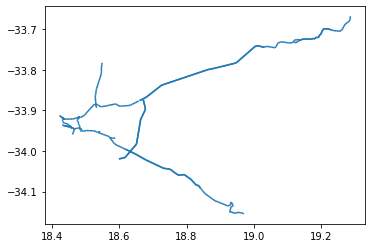

In [18]:
road_segments = gpd.read_file('road_segments/road_segments.shp')
road_segments.geometry.plot()
road_segments.head()

Getting locations of each segment

In [19]:
locations = df.groupby('road_segment_id').mean()[['longitude', 'latitude']]
locations.head()

,longitude,latitude
road_segment_id,,
03RHJ3G,18.460052,-33.943181
044ZYVD,18.555037,-33.890148
086LLYS,18.433149,-33.918991
0B0QOEN,18.477643,-33.917952
0F3OY57,18.773045,-34.057817


Adding weather info

In [20]:
w= pd.read_csv('weather.csv', sep=";", skiprows=6, usecols=range(14),
                      parse_dates=['Local time in Cape Town (airport)']) 
w.head()

,Local time in Cape Town (airport),T,P0,P,U,DD,Ff,ff10,WW,W'W',c,VV,Td,Unnamed: 13
0,2019-04-04 23:00:00,15.0,762.0,765.8,77.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 720 m, broken clouds...",10.0 and more,11.0,NaN
1,2019-04-04 22:00:00,16.0,761.2,765.0,77.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 570 m, broken clouds...",10.0 and more,12.0,NaN
2,2019-04-04 21:59:00,16.0,761.2,765.0,77.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 570 m, broken clouds...",10.0 and more,12.0,NaN
3,2019-04-04 21:01:00,15.0,761.2,765.0,94.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 150 m, broken clouds...",10.0 and more,14.0,NaN
4,2019-04-04 21:00:00,15.0,761.2,765.0,94.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 150 m, broken clouds...",10.0 and more,14.0,NaN


In [21]:
# Add dt column
w['dt'] = w['Local time in Cape Town (airport)'].dt.round('H')
w_cols = ['dt', 'T', 'P0', 'P', 'U', 'Ff']
w.head()

,Local time in Cape Town (airport),T,P0,P,U,DD,Ff,ff10,WW,W'W',c,VV,Td,Unnamed: 13,dt
0,2019-04-04 23:00:00,15.0,762.0,765.8,77.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 720 m, broken clouds...",10.0 and more,11.0,NaN,2019-04-04 23:00:00
1,2019-04-04 22:00:00,16.0,761.2,765.0,77.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 570 m, broken clouds...",10.0 and more,12.0,NaN,2019-04-04 22:00:00
2,2019-04-04 21:59:00,16.0,761.2,765.0,77.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 570 m, broken clouds...",10.0 and more,12.0,NaN,2019-04-04 22:00:00
3,2019-04-04 21:01:00,15.0,761.2,765.0,94.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 150 m, broken clouds...",10.0 and more,14.0,NaN,2019-04-04 21:00:00
4,2019-04-04 21:00:00,15.0,761.2,765.0,94.0,Wind blowing from the south-southeast,6.0,NaN,NaN,NaN,"Scattered clouds (40-50%) 150 m, broken clouds...",10.0 and more,14.0,NaN,2019-04-04 21:00:00


MERGE ALL DATA FOR TEST AND TRAIN

In [22]:
# merge the train data
train['datetime'] = pd.to_datetime(train['datetime'])
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.weekday
train['min'] = train['datetime'].dt.hour*60+train['datetime'].dt.minute
train = pd.merge(train, road_segments, on='segment_id', how='left') # Segment info
train = pd.merge(train, locations, left_on='segment_id', right_on='road_segment_id', how='left') # Segment locations
train = pd.merge(train, w[w_cols], left_on='datetime', right_on='dt', how='left') # Weather

# merge the test data to match train
test['datetime'] = pd.to_datetime(test['datetime'])
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.weekday
test['min'] = test['datetime'].dt.hour*60+test['datetime'].dt.minute
test = pd.merge(test, road_segments, on='segment_id', how='left')
test = pd.merge(test, locations, left_on='segment_id', right_on='road_segment_id', how='left')
test = pd.merge(test, w[w_cols], left_on='datetime', right_on='dt', how='left')

train.head()

,datetime x segment_id,datetime,segment_id,y,month,day,min,ROADNO,CLASS,REGION,...,length_1,geometry,longitude,latitude,dt,T,P0,P,U,Ff
0,2017-01-01 00:00:00 x S0B3CGQ,2017-01-01,S0B3CGQ,0,1,6,0,N1,Primary,Western Cape,...,521.765,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8...",18.541422,-33.888613,2017-01-01,22.0,756.8,760.5,73.0,8.0
1,2017-01-01 00:00:00 x RYJYAPI,2017-01-01,RYJYAPI,0,1,6,0,N2,Primary,Western Cape,...,521.945,"LINESTRING (18.93214 -34.13857, 18.93208 -34.1...",18.931088,-34.139930,2017-01-01,22.0,756.8,760.5,73.0,8.0
2,2017-01-01 00:00:00 x U3KP57C,2017-01-01,U3KP57C,0,1,6,0,N2,Primary,Western Cape,...,452.679,"LINESTRING (18.55332 -33.95934, 18.54963 -33.9...",18.550771,-33.958279,2017-01-01,22.0,756.8,760.5,73.0,8.0
3,2017-01-01 00:00:00 x RY0TRQ8,2017-01-01,RY0TRQ8,0,1,6,0,R300,Primary,Western Cape,...,493.974,"LINESTRING (18.67690 -33.89936, 18.67691 -33.8...",18.677475,-33.896611,2017-01-01,22.0,756.8,760.5,73.0,8.0
4,2017-01-01 00:00:00 x 8LOVJZ3,2017-01-01,8LOVJZ3,0,1,6,0,N2,Primary,Western Cape,...,569.263,"LINESTRING (18.83297 -34.08474, 18.83303 -34.0...",18.836121,-34.086109,2017-01-01,22.0,756.8,760.5,73.0,8.0


Create an equivalent dataset for submission

In [23]:
# Make the dataframe - dates based on sample submission file
dts = pd.date_range('2019-01-01 01:00:00',
                    '2019-03-31 23:00:00',
                    freq="1h")
tr = pd.DataFrame({'datetime':dts})

for segment_id in segment_ids:
    tr[str(segment_id)] = 0
    
ss = pd.DataFrame({
    'datetime x segment_id':np.concatenate([[str(x) + " x " + str(c)  for x in tr['datetime']for c in segment_ids]]),
    'datetime':np.concatenate([[str(x) for x in tr['datetime']for c in segment_ids]]),
    'segment_id':np.concatenate([[str(c) for x in tr['datetime']for c in segment_ids]])
})
ss.head()

,datetime x segment_id,datetime,segment_id
0,2019-01-01 01:00:00 x S0B3CGQ,2019-01-01 01:00:00,S0B3CGQ
1,2019-01-01 01:00:00 x RYJYAPI,2019-01-01 01:00:00,RYJYAPI
2,2019-01-01 01:00:00 x U3KP57C,2019-01-01 01:00:00,U3KP57C
3,2019-01-01 01:00:00 x RY0TRQ8,2019-01-01 01:00:00,RY0TRQ8
4,2019-01-01 01:00:00 x 8LOVJZ3,2019-01-01 01:00:00,8LOVJZ3


In [24]:
# Add the extra features
ss['datetime'] = pd.to_datetime(ss['datetime'])
ss['day'] = ss['datetime'].dt.weekday
ss['month'] = ss['datetime'].dt.month
ss['min'] = ss['datetime'].dt.hour*60+ss['datetime'].dt.minute
ss = pd.merge(ss, road_segments, on='segment_id', how='left')
ss = pd.merge(ss, locations, left_on='segment_id', right_on='road_segment_id', how='left')
ss = pd.merge(ss, w[w_cols], left_on='datetime', right_on='dt', how='left')
ss['prediction'] = 0
ss.head()

,datetime x segment_id,datetime,segment_id,day,month,min,ROADNO,CLASS,REGION,WIDTH,...,geometry,longitude,latitude,dt,T,P0,P,U,Ff,prediction
0,2019-01-01 01:00:00 x S0B3CGQ,2019-01-01 01:00:00,S0B3CGQ,1,1,60,N1,Primary,Western Cape,0.0,...,"LINESTRING (18.54354 -33.89011, 18.54268 -33.8...",18.541422,-33.888613,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0,0
1,2019-01-01 01:00:00 x RYJYAPI,2019-01-01 01:00:00,RYJYAPI,1,1,60,N2,Primary,Western Cape,12.8,...,"LINESTRING (18.93214 -34.13857, 18.93208 -34.1...",18.931088,-34.139930,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0,0
2,2019-01-01 01:00:00 x U3KP57C,2019-01-01 01:00:00,U3KP57C,1,1,60,N2,Primary,Western Cape,0.0,...,"LINESTRING (18.55332 -33.95934, 18.54963 -33.9...",18.550771,-33.958279,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0,0
3,2019-01-01 01:00:00 x RY0TRQ8,2019-01-01 01:00:00,RY0TRQ8,1,1,60,R300,Primary,Western Cape,20.2,...,"LINESTRING (18.67690 -33.89936, 18.67691 -33.8...",18.677475,-33.896611,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0,0
4,2019-01-01 01:00:00 x 8LOVJZ3,2019-01-01 01:00:00,8LOVJZ3,1,1,60,N2,Primary,Western Cape,20.2,...,"LINESTRING (18.83297 -34.08474, 18.83303 -34.0...",18.836121,-34.086109,2019-01-01 01:00:00,19.0,756.8,760.5,88.0,5.0,0


In [25]:
ss.dtypes

datetime x segment_id            object
datetime                 datetime64[ns]
segment_id                       object
day                               int64
month                             int64
min                               int64
ROADNO                           object
CLASS                            object
REGION                           object
WIDTH                           float64
LANES                             int64
SURFTYPE                         object
PAVETYPE                         object
CONDITION                        object
length_1                        float64
geometry                       geometry
longitude                       float64
latitude                        float64
dt                       datetime64[ns]
T                               float64
P0                              float64
P                               float64
U                               float64
Ff                              float64
prediction                        int64


MODELING - using catboost

In [26]:
x_cols = ['day', 'segment_id', 'min', 'longitude', 'latitude', 'ROADNO', 'length_1',  'LANES', 'CONDITION', 'month', 'T', 'P0', 'P', 'U', 'Ff']
cat_cols = ['day', 'month', 'segment_id', 'ROADNO',  'LANES', 'CONDITION']

In [27]:
from catboost import CatBoostClassifier

In [28]:
# Create the model
model2 = CatBoostClassifier(iterations=20, 
                           loss_function='Logloss', 
                           verbose=False) 

model2.fit(train[x_cols], train['y'], cat_features=cat_cols) # Takes about 

predicting model

In [29]:
from sklearn.metrics import f1_score

In [30]:
f1_score(test['y'], model2.predict(test[x_cols]))

0.0

MODELING- using LGBMClassifier

In [31]:
from lightgbm import LGBMClassifier
clf_lgbm = LGBMClassifier(n_estimators=100)

Do one hot encoding with the data in the x_cols3

In [32]:
x_cols3 = ['day', 'min', 'longitude', 'latitude', 'ROADNO', 'length_1',  'LANES', 'CONDITION', 'month', 'T', 'P0', 'P', 'U', 'Ff']

In [33]:
train_codified = pd.get_dummies(
                                    train[x_cols3], 
                                    drop_first=True,
                                    dtype="int64"
)

In [34]:
test_codified =pd.get_dummies(
                                    test[x_cols3], 
                                    drop_first=True,
                                    dtype="int64"
)

In [35]:
ss_codified= pd.get_dummies(
                                    ss[x_cols3], 
                                    drop_first=True,
                                    dtype="int64"
)

In [36]:
train_codified.columns

Index(['day', 'min', 'longitude', 'latitude', 'length_1', 'LANES', 'month',
       'T', 'P0', 'P', 'U', 'Ff', 'ROADNO_M3', 'ROADNO_M4', 'ROADNO_M5',
       'ROADNO_N1', 'ROADNO_N2', 'ROADNO_N7', 'ROADNO_R300',
       'ROADNO_Unclassified', 'CONDITION_Good', 'CONDITION_Unknown',
       'CONDITION_Very Good'],
      dtype='object')

Fitting model

In [37]:
clf_lgbm.fit(train_codified, train['y'])

LGBMClassifier()

Scoring model

In [38]:
f1_score(test['y'], clf_lgbm.predict(test_codified))

0.008462623413258109

HYPERPARAMETER TUNING- with LightGBMClassifier

In [40]:
clf_lgbm4 = LGBMClassifier(n_estimators=100, num_leaves=23,min_data_in_leaf = 18,num_iterations=80)

Fitting new model

In [41]:
clf_lgbm4.fit(train_codified, train['y'])

LGBMClassifier(min_data_in_leaf=18, num_iterations=80, num_leaves=23)

Scoring new model

In [44]:
f1_score(test['y'], clf_lgbm4.predict(test_codified))

0.01967089086438434

Changing threshold of new model

In [45]:
test_codified['pred'] = clf_lgbm4.predict_proba(test_codified)[:,1]
test_codified['gt02'] = (test_codified['pred']>0.017).astype(int)
f1_score(test['y'], test_codified['gt02'])

0.05402432854534657

MAKING SUBMISSION FILE

In [46]:
ss_codified.head()

,day,min,longitude,latitude,length_1,LANES,month,T,P0,P,...,ROADNO_M4,ROADNO_M5,ROADNO_N1,ROADNO_N2,ROADNO_N7,ROADNO_R300,ROADNO_Unclassified,CONDITION_Good,CONDITION_Unknown,CONDITION_Very Good
0,1,60,18.541422,-33.888613,521.765,0,1,19.0,756.8,760.5,...,0,0,1,0,0,0,0,0,1,0
1,1,60,18.931088,-34.139930,521.945,2,1,19.0,756.8,760.5,...,0,0,0,1,0,0,0,0,0,1
2,1,60,18.550771,-33.958279,452.679,0,1,19.0,756.8,760.5,...,0,0,0,1,0,0,0,0,1,0
3,1,60,18.677475,-33.896611,493.974,2,1,19.0,756.8,760.5,...,0,0,0,0,0,1,0,0,0,0
4,1,60,18.836121,-34.086109,569.263,2,1,19.0,756.8,760.5,...,0,0,0,1,0,0,0,0,0,1


In [47]:
ss_final = pd.concat([
                            ss_codified,
                            ss['datetime x segment_id'] # reset index so it matches the numerical
                        ], axis=1
)

In [48]:
ss_final['prediction'] = clf_lgbm4.predict_proba(ss_codified)[:, 1] 

In [49]:
ss_final.head()

,day,min,longitude,latitude,length_1,LANES,month,T,P0,P,...,ROADNO_N1,ROADNO_N2,ROADNO_N7,ROADNO_R300,ROADNO_Unclassified,CONDITION_Good,CONDITION_Unknown,CONDITION_Very Good,datetime x segment_id,prediction
0,1,60,18.541422,-33.888613,521.765,0,1,19.0,756.8,760.5,...,1,0,0,0,0,0,1,0,2019-01-01 01:00:00 x S0B3CGQ,0.001589
1,1,60,18.931088,-34.139930,521.945,2,1,19.0,756.8,760.5,...,0,1,0,0,0,0,0,1,2019-01-01 01:00:00 x RYJYAPI,0.000226
2,1,60,18.550771,-33.958279,452.679,0,1,19.0,756.8,760.5,...,0,1,0,0,0,0,1,0,2019-01-01 01:00:00 x U3KP57C,0.002012
3,1,60,18.677475,-33.896611,493.974,2,1,19.0,756.8,760.5,...,0,0,0,1,0,0,0,0,2019-01-01 01:00:00 x RY0TRQ8,0.000445
4,1,60,18.836121,-34.086109,569.263,2,1,19.0,756.8,760.5,...,0,1,0,0,0,0,0,1,2019-01-01 01:00:00 x 8LOVJZ3,0.000531


In [50]:
# Changing to binary with our threshold:
ss_final['prediction'] = (ss_final['prediction']>0.017).astype(int)

In [51]:
# Save to CSV and submit
ss_final[['datetime x segment_id', 'prediction']].to_csv('9th_try.csv', index=False)